In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import numpy as np
from collections import OrderedDict

from models.seir.seir_testing import SEIR_Testing
from utils.data import get_global_data, get_indian_data
from utils.plotting import create_plots
from utils.generic import init_params

In [89]:
df_master = get_global_data()

In [90]:
df_tested, df_statewise, df_state_time_series, df_india_time_series, df_districtwise, df_raw_data, df_travel_history = get_indian_data()

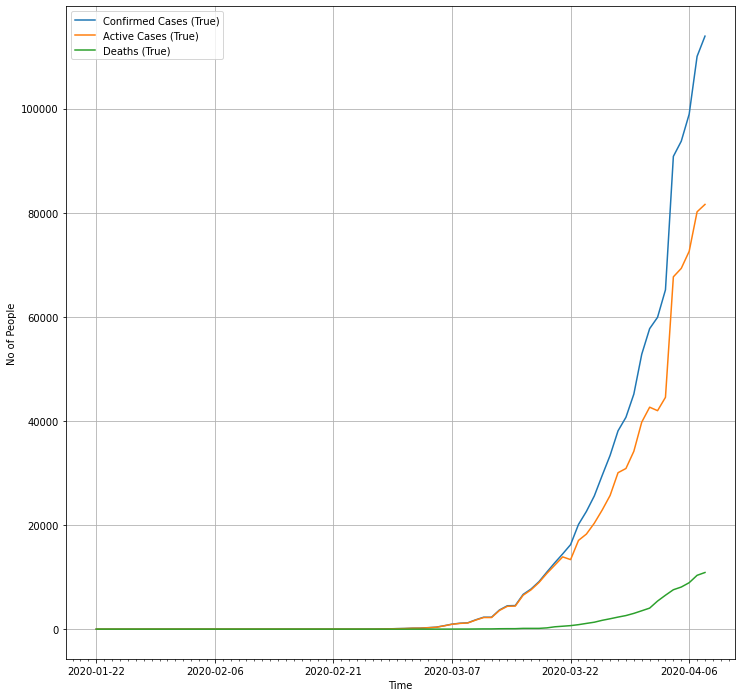

In [112]:
df_country = df_master[df_master['Country/Region'] == 'France'].loc[:, 'Date':].groupby('Date').sum().reset_index()
df_country[df_country['ConfirmedCases'] > 0]
last_time = len(df_country['Date'])

states_time_matrices = []
vanilla_params, testing_params, state_init_values = init_params(R0=3, T_inc=5.2, T_inf=2.9, T_death=1, N=6.05e7, init_infected=1)
solver = SEIR_Testing(vanilla_params, testing_params, state_init_values)
sol = solver.solve_ode(time_step=1, method='Radau')
states_time_matrices.append( (sol.y*vanilla_params['N']).astype('int') )
states_time_matrix = np.array(states_time_matrices)[0, :, :last_time]

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_country['Date'], df_country['ConfirmedCases'], label='Confirmed Cases (True)')
# ax.plot(np.array(df_country['Date']), states_time_matrix[2] + states_time_matrix[4] + 
#         states_time_matrix[5] + states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8] + 
#         states_time_matrix[9] + states_time_matrix[10], label='Confirmed Cases (Predicted)')
ax.plot(df_country['Date'], df_country['ActiveCases'], label='Active Cases (True)')
# ax.plot(df_country['Date'], states_time_matrix[2] + states_time_matrix[4] + states_time_matrix[5] + 
#         states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8], label='Active Cases (Predicted)')
ax.plot(df_country['Date'], df_country['Deaths'], label='Deaths (True)')
# ax.plot(df_country['Date'], states_time_matrix[10], label='Deaths (Predicted)')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People')
plt.xlabel('Time')
plt.legend()
plt.grid()
plt.show()

In [101]:
def calc_case_loss(states_time_matrix, df_country):
    pred_conf_cases = states_time_matrix[2] + states_time_matrix[4] + states_time_matrix[5] + states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8] + states_time_matrix[9] + states_time_matrix[10]
    pred_active_cases = states_time_matrix[2] + states_time_matrix[4] + states_time_matrix[5] + states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8]
    loss = np.sqrt(np.mean((pred_conf_cases - df_country['ConfirmedCases'])**2)) + np.sqrt(np.mean((pred_active_cases - df_country['ActiveCases'])**2))
    return loss

def calc_death_loss(states_time_matrix, df_country):
    return np.sqrt(np.mean((states_time_matrix[10] - df_country['Deaths'])**2))
    
def optimise(country='Italy', N=6.05e7):
    
    df_country = df_master[df_master['Country/Region'] == country].loc[:, 'Date':].groupby('Date').sum().reset_index()
    df_country = df_country[df_country['ConfirmedCases'] > 0]
    total_days = len(df_country['Date'])
    df_country.reset_index(drop=True, inplace=True)
    init_infected = df_country.loc[0, 'ConfirmedCases']
    
    loss_array = []
    params_array = []
    R_0_array = np.linspace(1, 4.8, 20)
    T_inc_array = np.linspace(1, 5.2, 22)
    T_inf_array = np.linspace(1, 5, 21)
    for R0 in R_0_array:
        for T_inc in T_inc_array:
            for T_inf in T_inf_array:
                #Solve ODE
                vanilla_params, testing_params, state_init_values = init_params(R0=R0, T_inc=T_inc, T_inf=T_inf, T_death=1, N=N, init_infected=init_infected)
                solver = SEIR_Testing(vanilla_params, testing_params, state_init_values)
                sol = solver.solve_ode(time_step=1, method='Radau')
                states_time_matrix = (sol.y*vanilla_params['N']).astype('int')[:, :total_days]
                
                # Compute Loss
                loss_array.append( calc_case_loss(states_time_matrix, df_country) )
                params_array.append({ 'R0' : R0, 'T_inc' : T_inc, 'T_inf' : T_inf })
                
    return loss_array, params_array

In [102]:
loss_array, params_array = optimise()

In [106]:
params_array[np.argmin(loss_array)]
np.min(loss_array)

44000.7628090772

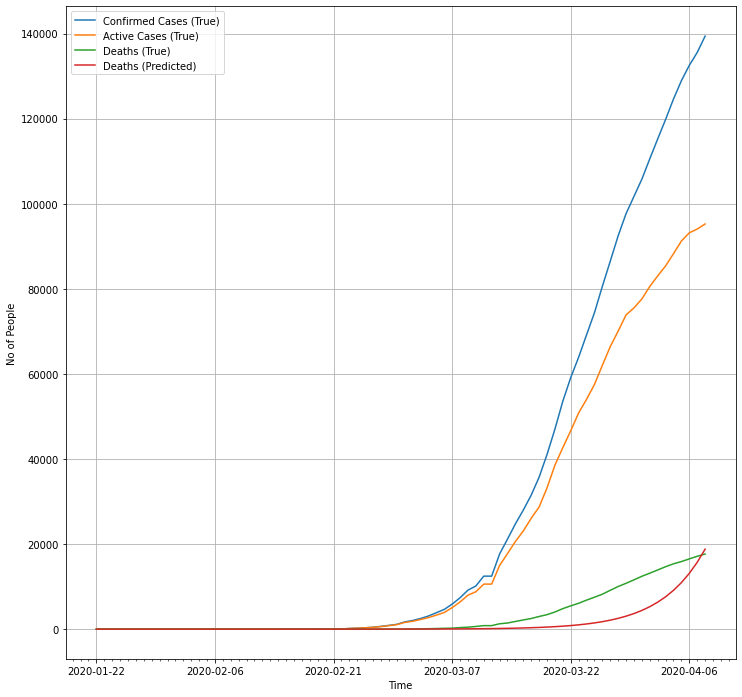

In [107]:
vanilla_params, testing_params, state_init_values = init_params(R0=1.4, T_inc=1.2, T_inf=1.2, T_death=1, N=6.05e7, init_infected=1)
solver = SEIR_Testing(vanilla_params, testing_params, state_init_values)
sol = solver.solve_ode(time_step=1, method='Radau')
states_time_matrices.append( (sol.y*vanilla_params['N']).astype('int') )
states_time_matrix = np.array(states_time_matrices)[0, :, :last_time]

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(df_country['Date'], df_country['ConfirmedCases'], label='Confirmed Cases (True)')
# ax.plot(np.array(df_country['Date']), states_time_matrix[2] + states_time_matrix[4] + 
#         states_time_matrix[5] + states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8] + 
#         states_time_matrix[9] + states_time_matrix[10], label='Confirmed Cases (Predicted)')
ax.plot(df_country['Date'], df_country['ActiveCases'], label='Active Cases (True)')
# ax.plot(df_country['Date'], states_time_matrix[2] + states_time_matrix[4] + states_time_matrix[5] + 
#         states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8], label='Active Cases (Predicted)')
ax.plot(df_country['Date'], df_country['Deaths'], label='Deaths (True)')
ax.plot(df_country['Date'], states_time_matrix[10], label='Deaths (Predicted)')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People')
plt.xlabel('Time')
plt.legend()
plt.grid()
plt.show()